In [165]:
import pandas as pd
import os

current_directory = os.getcwd()
print(f"\nCurrent working directory: {current_directory}\n")

#path_data = "Datasets\covid19-cough-audio-classification"
#filename = os.path.join(path_data, "metadata_compiled.csv")

path_data = "../vs_release_16k"
filename = os.path.join(path_data, "all_meta.csv")

data = pd.read_csv(filename, encoding="latin-1")


Current working directory: g:\Dokumente\Studium\MMI\Audio Data Science\GeoCougher



<Axes: ylabel='language'>

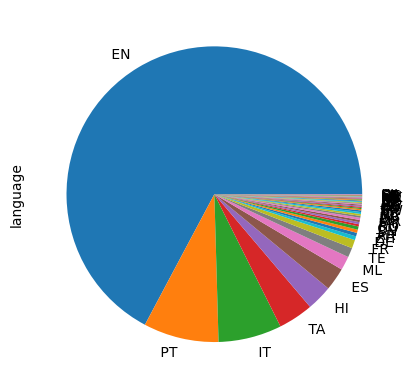

In [166]:
data.language.value_counts().plot(kind='pie')

In [167]:
data.head()

,ID,gender,age,country,language,sick
0,m0001,male,36,United States of America,EN,no
1,m0002,male,19,Italy,IT,yes
2,f0003,female,56,United States of America,EN,no
3,f0004,female,41,United States of America,EN,no
4,o0005,other,22,United States of America,EN,no


### add language family to data
The language data is heavily skewed towards English. So maybe it is better to use language families instead of languages.
I found a .tsv file, that maps ISO639-3 decoded languages to language families (decoded in ISO639-5).

In [168]:
# Load the ISO639-5 to ISO639-3 mapping from the .tsv file
iso_mapping_file = "iso639-5_to_iso639-3.tsv"
iso_mapping_tsv = pd.read_csv(iso_mapping_file, sep='\t', header=None, names=['iso639_5', 'glottolog', 'iso639_3'])
iso_mapping_tsv.head()

,iso639_5,glottolog,iso639_3
0,aav,aust1305,jah cwg kns knq tnz jhi mnq btq mzt sea tea ss...
1,afa,afro1255,auj gha jbn kab tzm shi gho sjs swn siz thv ta...
2,alg,algo1256,chy mez bla nwa arp ats atj moe nsk crm crl cr...
3,alv,atla1278,gol msw lma lia bun bmf buy kqs kss bmd bsp bg...
4,apa,apac1239,apk apj apl apm nav apw


We can see that multiple languages (iso639_3 column) belong to one language family (iso639_5 column) in the file. But to map the languages of our dataset to language families, its easier to flip this thing around, so we can look up a language and retrieve its language family. It is also important that one language can belong o multiple language families. So the language family column should be a list of language families:

In [169]:
# Create an empty dataframe to store the flipped data
iso_mapping_df = pd.DataFrame(columns=["iso639_5", "iso639_3"])

# Iterate over each row in the original dataframe
for index, row in iso_mapping_tsv.iterrows():
    # Check if the third column contains NaN (empty value)
    if pd.isna(row[2]):
        continue  # Skip this row if it's empty
    # Split the languages in the third column
    languages = row[2].split()
    # Create a temporary dataframe for the flipped data
    temp_df = pd.DataFrame({"iso639_5": row[0], "iso639_3": languages})
    # Concatenate the temporary dataframe with the flipped dataframe
    iso_mapping_df = pd.concat([iso_mapping_df, temp_df], ignore_index=True)

# Display the flipped dataframe
iso_mapping_df.head()

,iso639_5,iso639_3
0,aav,jah
1,aav,cwg
2,aav,kns
3,aav,knq
4,aav,tnz


The language code in the original dataset is decoded in ISO639-1. Not ISO639-3. So we need to convert that, too. Thats super easy, because theres a paython package for that called languagecodes:

In [170]:
import languagecodes

# add iso639_3 column to the data
data['iso639_3'] = data['language'].apply(languagecodes.iso_639_alpha3)
data.head()

,ID,gender,age,country,language,sick,iso639_3
0,m0001,male,36,United States of America,EN,no,eng
1,m0002,male,19,Italy,IT,yes,ita
2,f0003,female,56,United States of America,EN,no,eng
3,f0004,female,41,United States of America,EN,no,eng
4,o0005,other,22,United States of America,EN,no,eng


In [171]:
# add language families in iso639_5 column to the data
for index, row in data.iterrows():                               # Iterate over each row in the data        
    if pd.isna(row['iso639_3']):                                 # Skip if the iso639_3 column is empty
        continue
    
    mask = iso_mapping_df['iso639_3'] == row['iso639_3']        # Mask to find the corresponding rows in the iso_mapping_df
    language_families = iso_mapping_df[mask]['iso639_5'].values # split the content of the iso639_5 column into an array of stings
    data.at[index, 'iso639_5'] = ", ".join(language_families)

# split the iso639_5 column into three columns, for easaier handling
family_columns = data.iso639_5.str.split(", ", expand=True)
family_columns.columns = ["family1", "family2", "family3"]
data = pd.concat([data, family_columns], axis=1)
data.head()

,ID,gender,age,country,language,sick,iso639_3,iso639_5,family1,family2,family3
0,m0001,male,36,United States of America,EN,no,eng,"gem, gmw, ine",gem,gmw,ine
1,m0002,male,19,Italy,IT,yes,ita,"ine, itc, roa",ine,itc,roa
2,f0003,female,56,United States of America,EN,no,eng,"gem, gmw, ine",gem,gmw,ine
3,f0004,female,41,United States of America,EN,no,eng,"gem, gmw, ine",gem,gmw,ine
4,o0005,other,22,United States of America,EN,no,eng,"gem, gmw, ine",gem,gmw,ine


In [172]:

# no language family for the following languages
pd.isna(data.iso639_5).sum()

0

### Check Sneeze data

In [173]:
def get_dataframe_from_class_label(directory, class_label):
    files = os.listdir(directory)
    class_files = [file for file in files if class_label in file]
    # Create a DataFrame from class_files
    class_df = pd.DataFrame(class_files, columns=['filename'])

    # Extract the ID from the filename
    class_df['ID'] = class_df['filename'].str.extract('([a-z]\\d+)')
    # Merge class_df with data on the ID column

    merged_df = pd.merge(class_df, data, on='ID')
    return merged_df

 EN    787
 PT     86
 IT     78
 TA     46
 HI     33
 ES     25
 ML     13
 TE     11
 FR     11
 DE      5
 MR      4
 BN      3
 AR      3
 RU      3
 KO      2
 RO      2
 SQ      2
 NL      2
 UR      2
 ZH      2
 VI      2
 GU      2
 FA      2
 ET      1
 ID      1
 UK      1
 SW      1
 AF      1
 BG      1
 HE      1
 HY      1
 PA      1
 LV      1
Name: language, dtype: int64


<Axes: ylabel='language'>

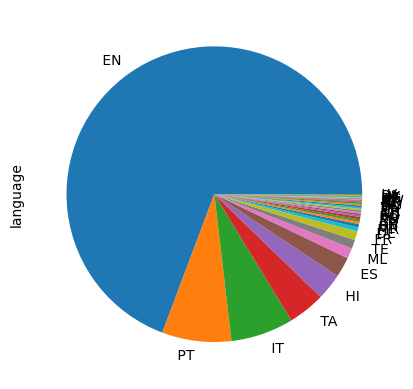

In [174]:
vocalsound_directory = "../vs_release_16k/audio_16k"
sneeze_data = get_dataframe_from_class_label(vocalsound_directory, "sneeze")
print(sneeze_data.language.value_counts())
sneeze_data.language.value_counts().plot(kind='pie')

ine    1049
gem     795
gmw     795
itc     202
roa     202
dra      70
iir      45
inc      45
         13
sla       5
zle       4
aav       2
mkh       2
map       1
afa       1
bat       1
poz       1
sem       1
zls       1
dtype: int64


<Axes: >

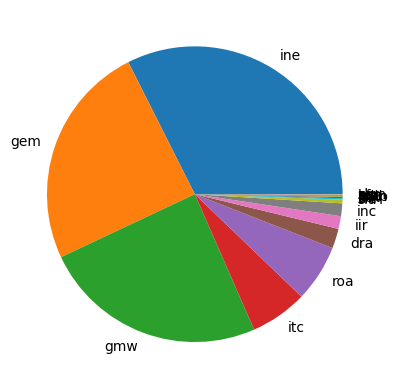

In [175]:
sneeze_family_counts = pd.concat([sneeze_data['family1'], sneeze_data['family2'], sneeze_data['family3']]).value_counts()
print(sneeze_family_counts)
sneeze_family_counts.plot(kind='pie')

<Axes: ylabel='language'>

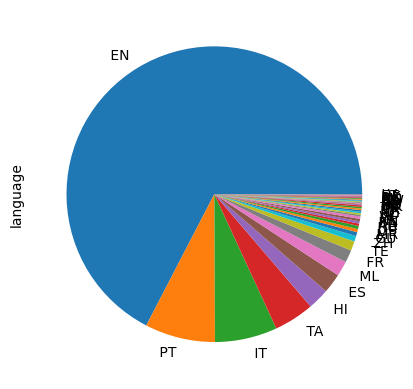

In [176]:
laughter_data = get_dataframe_from_class_label(vocalsound_directory, "laughter")
laughter_data.language.value_counts().plot(kind='pie')

ine    1049
gem     789
gmw     789
roa     211
itc     211
dra      82
inc      42
iir      42
         19
sla       6
zle       4
mkh       2
poz       2
zls       2
aav       2
urj       2
map       2
trk       2
afa       1
sem       1
bat       1
dtype: int64


<Axes: >

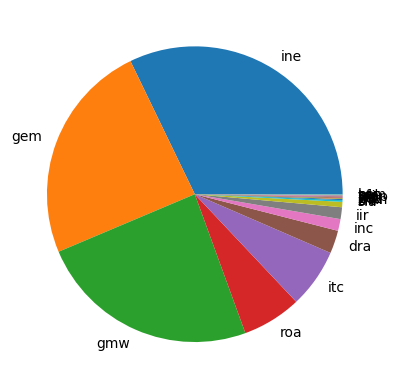

In [177]:
laughter_family_counts = pd.concat([laughter_data['family1'], laughter_data['family2'], laughter_data['family3']]).value_counts()
print(laughter_family_counts)
laughter_family_counts.plot(kind='pie')